In [94]:
from data_load import load_netcdf
from models import datetimeToSignal
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

In [157]:
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

c:\Studia\maciej-romanski\data_load.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [158]:
df = datetimeToSignal(df)

In [159]:
df['y'] = df['windspeed_100'].shift(-1)
df = df.drop(df.tail(1).index)

In [160]:
X = df.loc[:, df.columns != 'y'].values
y = df['y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)

Baseline

In [161]:
baseline_pred = X_test[:, 6]

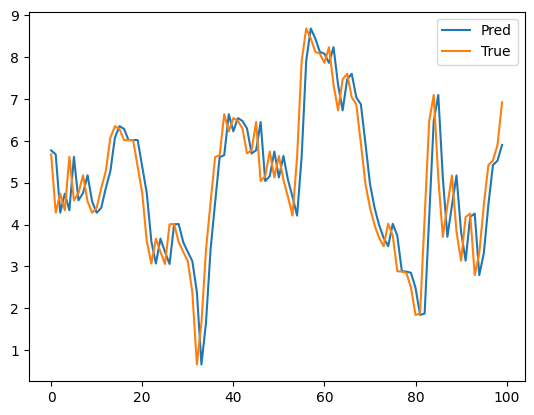

In [162]:
plt.plot(baseline_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

Decision tree

In [163]:
dt_reg = DecisionTreeRegressor(random_state=42)

dt_reg.fit(X_train, y_train)

dt_reg_pred = dt_reg.predict(X_test)

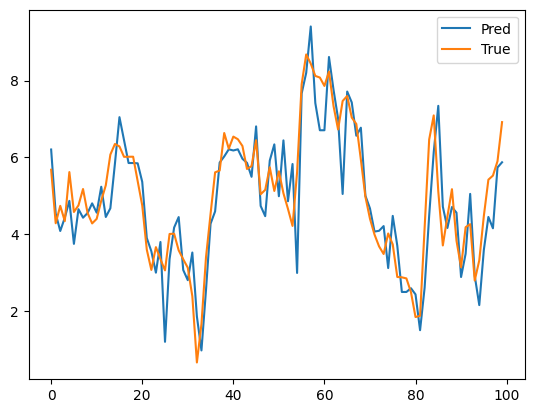

In [164]:
plt.plot(dt_reg_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

Text(0.5, 1.0, 'Cross correlation between predictions and actual values')

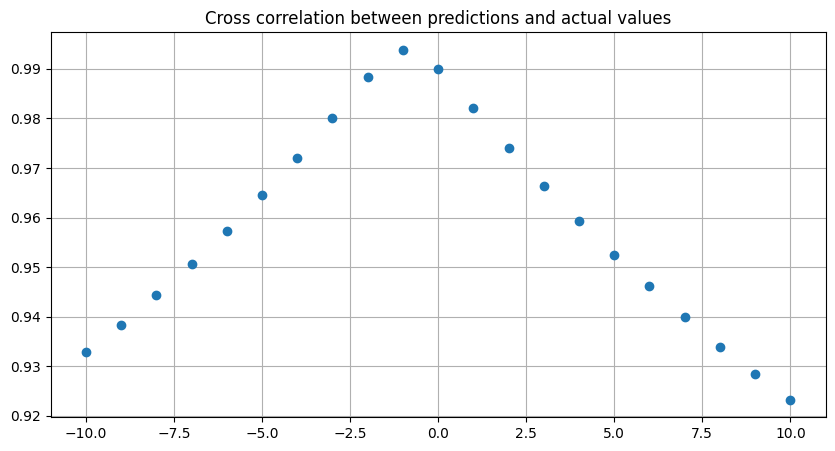

In [165]:
plt.figure(figsize=[10,5])
plt.xcorr(y_test, dt_reg_pred, usevlines=False)
plt.grid()
plt.title("Cross correlation between predictions and actual values")

Gradient boosting

In [166]:
gbr = GradientBoostingRegressor(random_state=42)

gbr.fit(X_train, y_train.ravel())

gbr_pred = gbr.predict(X_test)

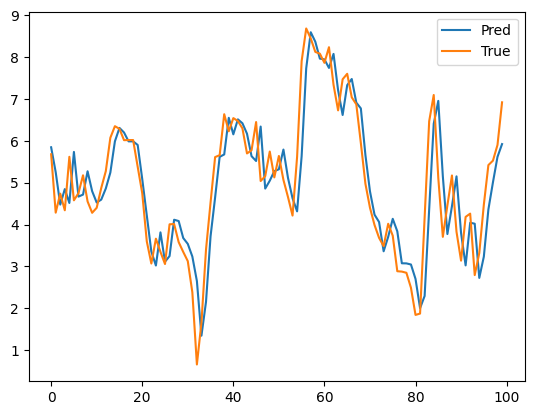

In [167]:
plt.plot(gbr_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

Text(0.5, 1.0, 'Cross correlation between predictions and actual values')

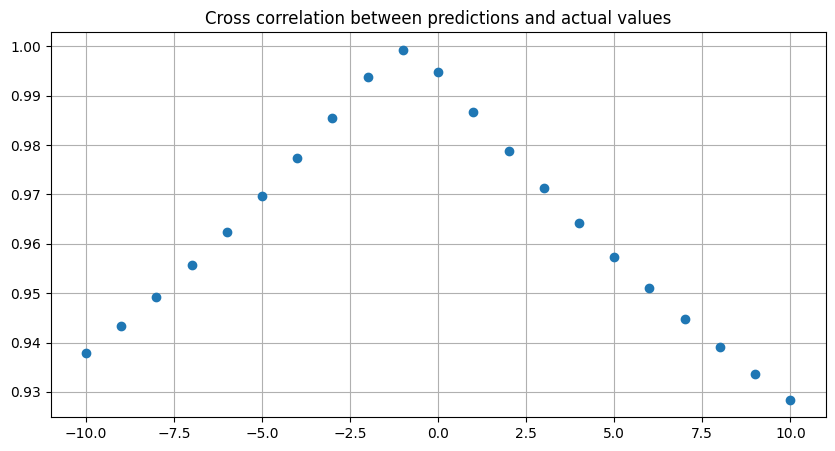

In [168]:
plt.figure(figsize=[10,5])
plt.xcorr(y_test, gbr_pred, usevlines=False)
plt.grid()
plt.title("Cross correlation between predictions and actual values")

SVM

In [169]:
svr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2, verbose=True))

svr.fit(X_train, y_train)

svr_pred = svr.predict(X_test)

[LibSVM]

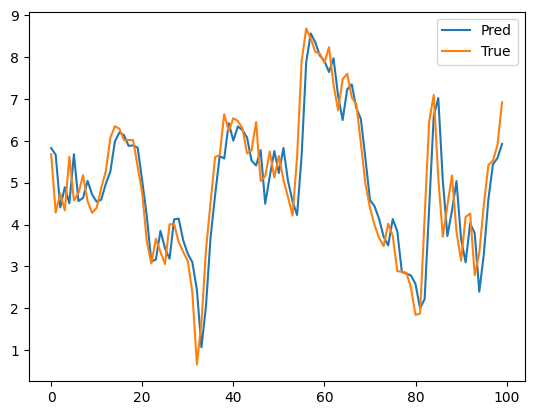

In [170]:
plt.plot(svr_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

Text(0.5, 1.0, 'Cross correlation between predictions and actual values')

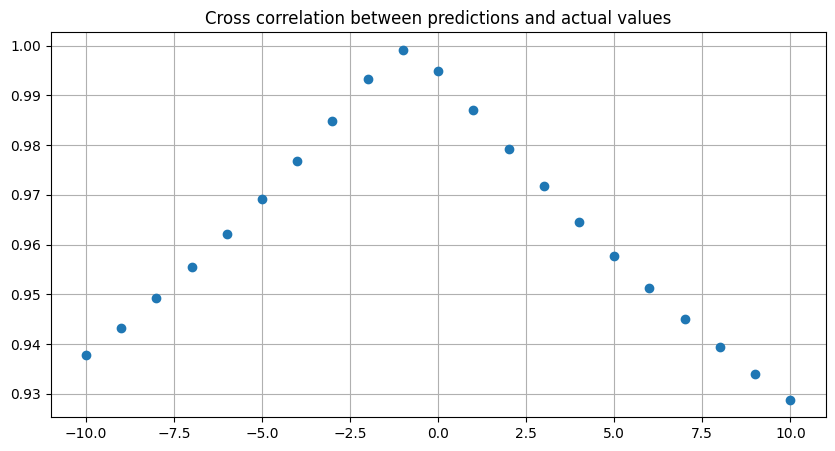

In [171]:
plt.figure(figsize=[10,5])
plt.xcorr(y_test, svr_pred, usevlines=False)
plt.grid()
plt.title("Cross correlation between predictions and actual values")

Evaluation

In [172]:
def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

def rmse(y_true, y_pred):
    return round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)

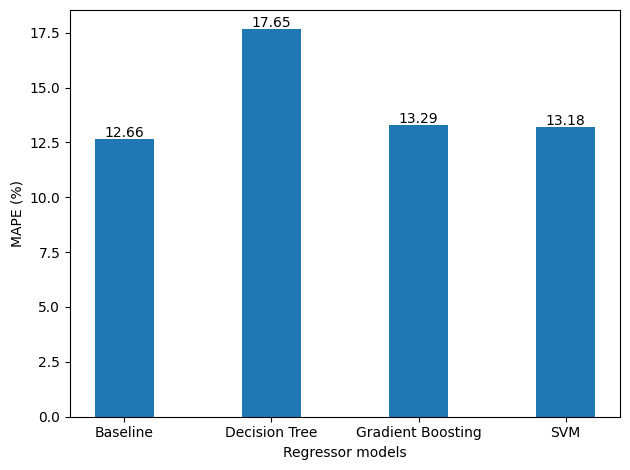

In [173]:
baseline_mape = mape(y_test, baseline_pred)
dt_mape = mape(y_test, dt_reg_pred)
gbr_mape = mape(y_test, gbr_pred)
svr_mape = mape(y_test, svr_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting', 'SVM']
y = [baseline_mape, dt_mape, gbr_mape, svr_mape]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('MAPE (%)')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.1, s=str(value), ha='center')
    
plt.tight_layout()

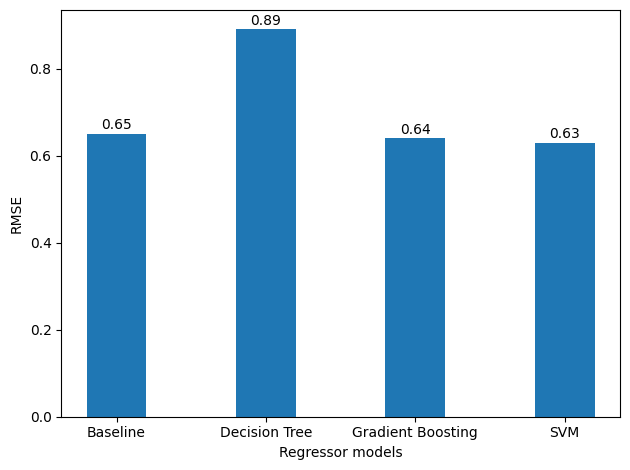

In [174]:
baseline_rmse = rmse(y_test, baseline_pred)
dt_rmse = rmse(y_test, dt_reg_pred)
gbr_rmse = rmse(y_test, gbr_pred)
svr_rmse = rmse(y_test, svr_pred)
# Generate the bar plot
fig, ax = plt.subplots()

x = ['Baseline', 'Decision Tree', 'Gradient Boosting', 'SVM']
y = [baseline_rmse, dt_rmse, gbr_rmse, svr_rmse]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Regressor models')
ax.set_ylabel('RMSE')
# ax.set_ylim(0, 2.5)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.01, s=str(value), ha='center')
    
plt.tight_layout()

Neural network:

In [179]:
from models import data_prep, compile_and_fit

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Reshape
from keras.layers import Flatten

In [176]:
df_nn = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

c:\Studia\maciej-romanski\data_load.py:88: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [208]:
X_train, y_train, X_test, y_test, scaler_y = data_prep(df_nn, 2014, 2020, 2021, 2021, 24, 1, y_featurename='windspeed_100')

In [178]:
X_train.shape

(61338, 24, 11)

In [198]:
dense = Sequential([
    Flatten(), # Shape: (time, features) => (time*features)
    Dense(units=200, activation='relu'),
    # Dropout(0.2),
    Dense(units=200, activation='relu'),
    # Dropout(0.2),
    Dense(units=200, activation='relu'),
    # Dropout(0.2),
    Dense(1),
    # Reshape([1,X_train.shape[1]]),
    # Dense(1),
    Reshape([1, -1]) # Shape: (outputs) => (1, outputs) Adding back time dimention
])

compile_and_fit(dense, X_train, y_train)

Epoch 1/20
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0026
Epoch 2/20
1917/1917 [==============================] - 3s 2ms/step - loss: 0.0012
Epoch 3/20
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0010
Epoch 4/20
1917/1917 [==============================] - 3s 2ms/step - loss: 0.0010
Epoch 5/20
1917/1917 [==============================] - 3s 2ms/step - loss: 9.5159e-04
Epoch 6/20
1917/1917 [==============================] - 3s 2ms/step - loss: 9.2801e-04
Epoch 7/20
1917/1917 [==============================] - 3s 2ms/step - loss: 9.1057e-04
Epoch 8/20
1917/1917 [==============================] - 4s 2ms/step - loss: 8.7736e-04
Epoch 9/20
1917/1917 [==============================] - 4s 2ms/step - loss: 8.6631e-04
Epoch 10/20
1917/1917 [==============================] - 4s 2ms/step - loss: 8.6461e-04
Epoch 11/20
1917/1917 [==============================] - 4s 2ms/step - loss: 8.4183e-04
Epoch 12/20
1917/1917 [==============================] - 

273/273 [==============================] - 0s 1ms/step


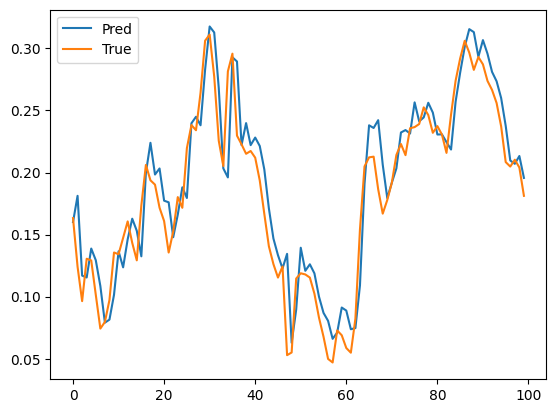

In [201]:
dense_pred = dense.predict(X_test)
dense_pred = dense_pred.reshape((dense_pred.shape[0],1))
plt.plot(dense_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

Text(0.5, 1.0, 'Cross correlation between predictions and actual values')

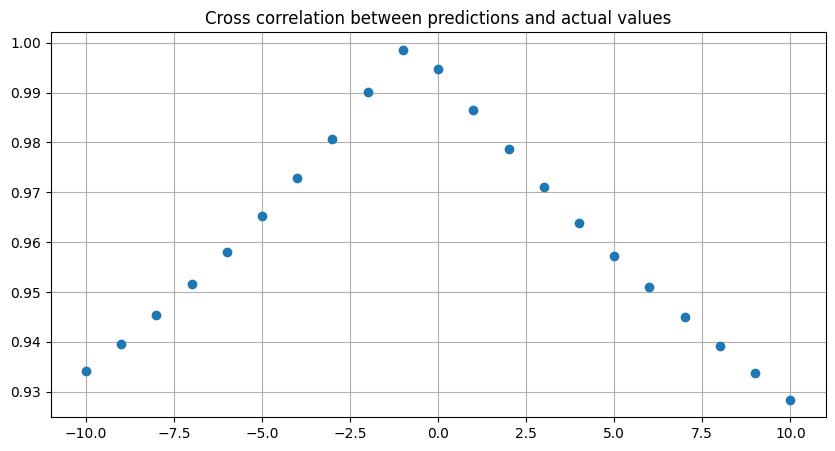

In [202]:
plt.figure(figsize=[10,5])
plt.xcorr(y_test.reshape(y_test.shape[0]), dense_pred.reshape(dense_pred.shape[0]), usevlines=False)
plt.grid()
plt.title("Cross correlation between predictions and actual values")

In [203]:
dense_pred = scaler_y.inverse_transform(dense_pred)
dense_pred = dense_pred.reshape(dense_pred.shape[0])
y_test = scaler_y.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

dense_mape = mape(y_test, dense_pred)
dense_rmse = rmse(y_test, dense_pred)

print(f"MAPE = {dense_mape}")
print(f"RMSE = {dense_rmse}")

MAPE = 14.95
RMSE = 0.63


In [204]:
lstm = Sequential([
    LSTM(32, return_sequences=True), # Shape [batch, time, features] => [batch, time, lstm_units]
    Dense(units=1) # Shape => [batch, time, features]
])

compile_and_fit(lstm, X_train, y_train)

Epoch 1/20
1917/1917 [==============================] - 14s 6ms/step - loss: 0.0098
Epoch 2/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.0085
Epoch 3/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.0083
Epoch 4/20
1917/1917 [==============================] - 13s 7ms/step - loss: 0.0082
Epoch 5/20
1917/1917 [==============================] - 12s 7ms/step - loss: 0.0081
Epoch 6/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.0081
Epoch 7/20
1917/1917 [==============================] - 13s 7ms/step - loss: 0.0080
Epoch 8/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.0080
Epoch 9/20
1917/1917 [==============================] - 13s 7ms/step - loss: 0.0079
Epoch 10/20
1917/1917 [==============================] - 12s 7ms/step - loss: 0.0078
Epoch 11/20
1917/1917 [==============================] - 12s 6ms/step - loss: 0.0078
Epoch 12/20
1917/1917 [==============================] - 12s 6ms/step - lo

273/273 [==============================] - 1s 3ms/step


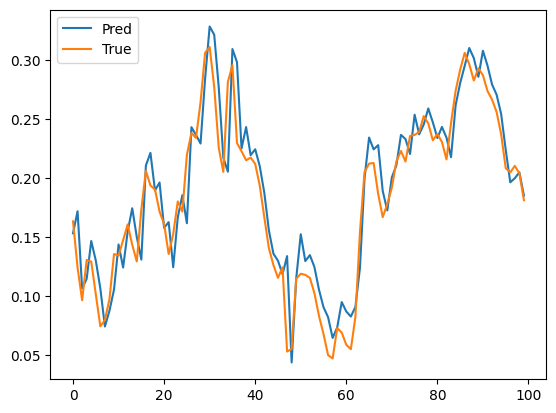

In [209]:
lstm_pred = lstm.predict(X_test)
lstm_pred = lstm_pred[:,-1,:]
lstm_pred = lstm_pred.reshape((lstm_pred.shape[0],1))
plt.plot(lstm_pred[:100])
plt.plot(y_test[:100])
plt.legend(['Pred', 'True'])

In [210]:
lstm_pred = scaler_y.inverse_transform(lstm_pred)
lstm_pred = lstm_pred.reshape(lstm_pred.shape[0])
y_test = scaler_y.inverse_transform(y_test)
y_test = y_test.reshape(y_test.shape[0])

lstm_mape = mape(y_test, lstm_pred)
lstm_rmse = rmse(y_test, lstm_pred)

print(f"MAPE = {dense_mape}")
print(f"RMSE = {dense_rmse}")

MAPE = 14.95
RMSE = 0.63
